In [1]:
import os, sys, re, pickle
import numpy as np
import pandas as pd

In [2]:
sys.path.insert(0, '/home/jgutman/mvesc/ETL')
sys.path.insert(0, '/home/jgutman/mvesc/Models_Results')

In [3]:
from mvesc_utility_functions import *

In [4]:
import itertools
from my_timer import Timer

In [35]:
from save_reports import *

In [40]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
model_list = ["'RF'", "'logit'"]
batch_date = '08_17_2016'
table_name = '_'.join(['best_models', batch_date])
outcome = 'definite_plus_ogt'

with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        temp_explore_results = """
        drop table if exists {table};
        create temporary table {table} as
            select model_name, filename, prediction_grade, label, 
            val_set, val_recall_5_15, test_set, test_recall_5_15 
            from model.reports
            where filename in 
                (select distinct on (prediction_grade, model_name)
                filename from model.reports
                where filename like '{batch_date}%'
                and cv_criterion like 'custom_recall%'
                and model_name in ({model_list})
                and label like '{outcome}'
                order by prediction_grade, model_name, cv_score desc)
            and cv_criterion like 'custom_recall%'
            order by model_name, prediction_grade;
        """.format(table = table_name, batch_date=batch_date,
                      model_list = ', '.join(model_list), outcome = outcome)
        cursor.execute(temp_explore_results)
        
        get_val_test_years = """
        select prediction_grade, val_set, test_set
            from {table} where model_name = {first_model}
        """.format(table = table_name, first_model = model_list[0])
        cursor.execute(get_val_test_years)
        val_test_years = cursor.fetchall()
        
        store_outcome_counts = pd.DataFrame(index = [year[0] for year in val_test_years], 
                columns = ['val_set', 'val_neg', 'val_pos', 'val_pct_pos',
                           'test_set', 'test_neg', 'test_pos', 'test_pct_pos'])
        for grade, val, test in val_test_years:
            get_counts = """ select count({outcome})
                from model.outcome where cohort_{grade}th in ({val}, {test})
                and {outcome} is not null
                group by (cohort_{grade}th, {outcome})
                order by (cohort_{grade}th, {outcome});
            """.format(outcome = outcome, grade = grade, val = val, test = test)
            cursor.execute(get_counts)
            results = [i[0] for i in cursor.fetchall()]
            store_outcome_counts.loc[grade] = [val, results[0], results[1], 
                results[1]/(results[0]+results[1]), test, results[2], results[3],
                results[3]/(results[2]+results[3])]

In [7]:
store_outcome_counts

,val_set,val_neg,val_pos,val_pct_pos,test_set,test_neg,test_pos,test_pct_pos
6,2008,875,107,0.108961,2009,930,88,0.086444
7,2009,891,110,0.10989,2010,1036,117,0.101474
8,2010,1113,141,0.11244,2011,1801,226,0.111495
9,2011,1881,276,0.127955,2012,2037,281,0.121225
10,2012,1838,252,0.120574,2013,2034,252,0.110236


In [8]:
def color_gt(val,x=.5,c='blue',neg=True):
    """
    Colors values greater than x blue (or other provided color)
    
    :param float x: lower bound on colored values
    :param str c: color
    :param bool neg: if true, color negative values red
    :returns: css string to color values in dataframe
    :rtype: str
    """
    
    if val > x:
        color = c 
    elif val < 0:
        color = 'red' 
    else: color = 'black'
    return 'color: %s' % color

def table_exists(cursor, table, schema='clean'):
    """
    Checks to see if a table exists in the database
    
    :param pg.cursor cursor: 
    :param str table:
    :param str schema:
    :rtype: bool
    """
    cursor.execute("""                                                   
            select count(*) from information_schema.tables                       
            where table_schema = %s and table_name = %s
            """, [schema, table])
    return cursor.fetchall()[0][0]

In [9]:
def plot_metric(y_scores, y_true, ax, gr, max_k, metric='recall'):
    if type(y_scores) != pd.core.series.Series:
        try:
            y_scores = pd.Series(y_scores)
        except:
            print('y_scores must be a Series or a DataFrame')
            sys.exit(1)
            
    n = int(len(y_scores)*(max_k))
    curve = np.zeros([n,1])
    ranks = y_scores.rank(method='first', ascending=False)
    if metric=='recall':
        scorer = recall_score
    elif metric=='precision':
        scorer = precision_score
    else:
        print('metric not found')
    for i in range(n):
        pred = pd.Series([1 if r <= i+1 else 0 for r in ranks])
        curve[i] = scorer(y_true, pred)
    
    percents = (np.arange(n)+1)/len(y_scores)
    ax.plot(percents, curve, label = str(gr))

In [10]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        select_models = """
        select * from model.reports where filename in 
        (select distinct on (prediction_grade, model_name) 
            filename from model.reports
            where filename like '08_17_2016%'
            and cv_criterion like 'custom_recall%'
            order by prediction_grade, model_name, cv_score desc)
        and cv_criterion like 'custom_recall%'
        order by model_name, prediction_grade;
        """
        cursor.execute(select_models)
        results_raw = cursor.fetchall()
        cols = [desc[0] for desc in cursor.description]
results = pd.DataFrame(results_raw, columns=cols)
print(results.filename)

0       08_17_2016_grade_6_param_set_8_logit_jg_97
1     08_17_2016_grade_7_param_set_17_logit_jg_100
2     08_17_2016_grade_8_param_set_16_logit_jg_111
3     08_17_2016_grade_9_param_set_22_logit_jg_127
4    08_17_2016_grade_10_param_set_22_logit_jg_123
5         08_17_2016_grade_6_param_set_8_RF_jg_136
6        08_17_2016_grade_7_param_set_17_RF_jg_138
7        08_17_2016_grade_8_param_set_16_RF_jg_161
8        08_17_2016_grade_9_param_set_22_RF_jg_171
9       08_17_2016_grade_10_param_set_16_RF_jg_139
Name: filename, dtype: object


In [23]:
scores_list = dict()
scores = dict()
y_list = dict()
y = dict()
grade_range = pd.unique(results.prediction_grade)

with Timer('reading_in_predictions') as t:
    with postgres_pgconnection_generator() as connection:
        with connection.cursor() as cursor:
            for (filename, model, gr) in \
                    zip(results.filename, results.model_name, results.prediction_grade):
                cursor.execute("""
                select student_lookup, true_label, predicted_score, split 
                from model.predictions_new
                where filename = '{}' 
                and split != 'train';""".format(filename))
                temp = pd.DataFrame.from_records(cursor.fetchall(), 
                    columns = [i[0] for i in cursor.description],
                    index = 'student_lookup')
                if model not in scores_list:
                    scores_list[model] = list()
                    y_list[model] = list()
                scores_list[model].append(pd.DataFrame(temp.predicted_score))
                y_list[model].append(pd.DataFrame(temp.true_label))
                run_time = t.time_check()
                print('model {0} grade {1}: time {2}'.format(model, gr, run_time))

model logit grade 6: time 22.76857280731201
model logit grade 7: time 23.334986448287964
model logit grade 8: time 23.913077354431152
model logit grade 9: time 24.46123218536377
model logit grade 10: time 25.019453048706055
model RF grade 6: time 25.533109426498413
model RF grade 7: time 26.064043283462524
model RF grade 8: time 26.614065647125244
model RF grade 9: time 27.190630197525024
model RF grade 10: time 27.752886533737183
reading_in_predictions: 2.8e+01 seconds elapsed


In [24]:
for model in pd.unique(results.model_name):
    for i, gr in enumerate(grade_range):
        scores_list[model][i].rename(columns = {
            'predicted_score': 'predicted_score_{0}'.format(gr)}, inplace=True)
        y_list[model][i].rename(columns = {
            'true_label': 'true_label_{0}'.format(gr)}, inplace=True)

    scores[model] = scores_list[model][0]
    y[model] = y_list[model][0]
    for df in scores_list[model][1:]:
        scores[model] = scores[model].join(df, how='inner')        
    for df in y_list[model][1:]:
        y[model] = y[model].join(df, how='inner')

In [32]:
scores['RF'].head()

,predicted_score_6,predicted_score_7,predicted_score_8,predicted_score_9,predicted_score_10
student_lookup,,,,,
12524.0,0.607354,0.522992,0.607711,0.562833,0.684964
269.0,0.025179,0.041288,0.007333,0.000667,0.020828
286.0,0.100005,0.103867,0.002750,0.004667,0.061586
596.0,0.034607,0.052583,0.123260,0.019786,0.193518
624.0,0.681687,0.608800,0.575310,0.446617,0.562096


In [33]:
scores['logit'].head()

,predicted_score_6,predicted_score_7,predicted_score_8,predicted_score_9,predicted_score_10
student_lookup,,,,,
12524.0,0.517524,0.405282,0.667096,0.467770,0.521509
269.0,0.025756,0.023818,0.003944,0.003294,0.002252
286.0,0.127087,0.025698,0.013667,0.004812,0.009442
596.0,0.011886,0.011378,0.048726,0.022327,0.062994
624.0,0.548608,0.428403,0.644857,0.417857,0.531235


precision_recall for RF at 6


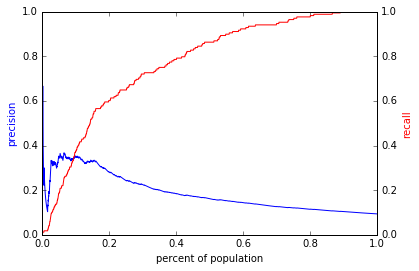

precision_recall for RF at 7


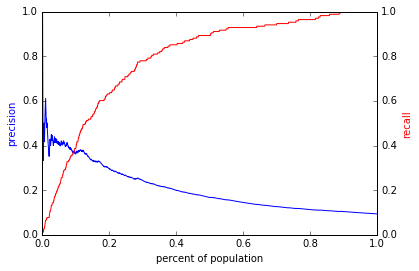

precision_recall for RF at 8


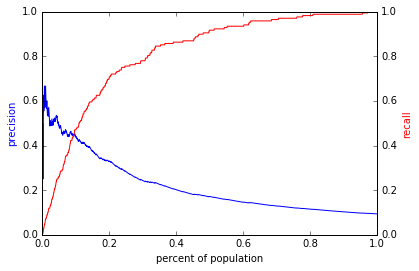

precision_recall for RF at 9


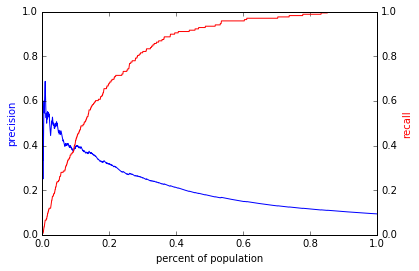

precision_recall for RF at 10


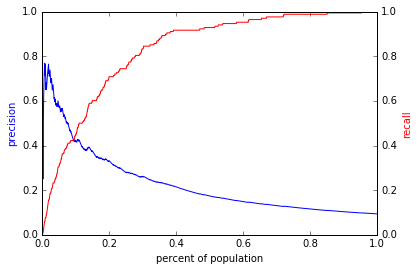

precision_recall for logit at 6


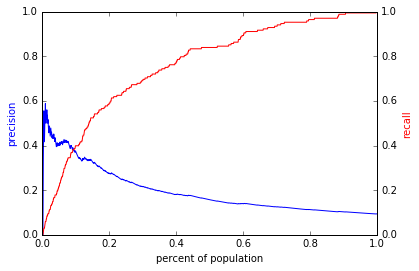

precision_recall for logit at 7


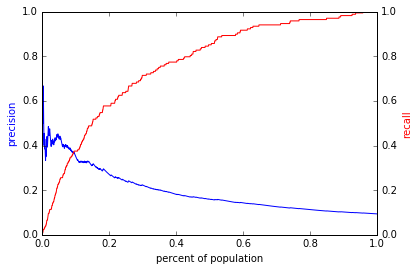

precision_recall for logit at 8


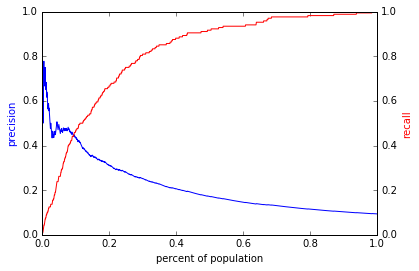

precision_recall for logit at 9


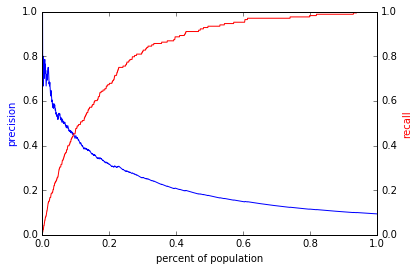

precision_recall for logit at 10


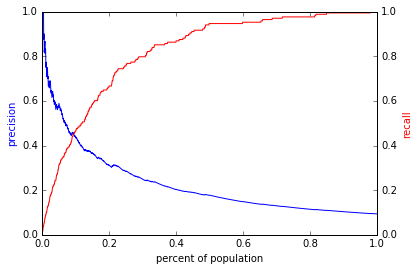

In [44]:
for model in ['RF', 'logit']:
    for grade in range(6,11):
        print('precision_recall for {model} at {grade}'.format(model=model, grade=grade))
        plot_precision_recall_n(y[model]['true_label_{}'.format(grade)], 
            scores[model]['predicted_score_{}'.format(grade)], 
            '/home/jgutman/mvesc/Reports', 'grade_{}'.format(grade), model)
        plt.show()

In [ ]:
max_k = .25
for model in ['RF', 'logit']:
    plt.clf()
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()

    for gr in np.arange(10,5,-1):
        plot_metric(scores[model]['predicted_score_{}'.format(gr)], 
                    y[model]['true_label_{}'.format(gr)], ax1, gr, max_k, 'recall')
        plot_metric(scores[model]['predicted_score_{}'.format(gr)], 
                    y[model]['true_label_{}'.format(gr)], ax2, gr, max_k, 'precision')

    plt.figure(fig1.number)
    ax1.legend(loc="lower right")
    ax1.set_xlabel("% of students", fontsize=18)
    ax1.set_ylabel('recall in {}'.format(model), fontsize=18)
    ax1.set_ylim([0,1])
    ax1.set_xlim([0,max_k])
    plt.savefig('recall_comparison_{}_08_17_2016.png'.format(model))

    plt.figure(fig2.number)
    ax2.legend(loc="upper right", ncol=2)
    ax2.set_xlabel("% of students", fontsize=18)
    ax2.set_ylabel('precision in {}'.format(model), fontsize=18)
    ax2.set_ylim([0,1])
    ax2.set_xlim([0,max_k])
    plt.savefig('precision_comparison_{}_08_17_2016.png'.format(model))
    plt.show()